In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingLR
import albumentations
import timm

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from pylab import rcParams

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GroupKFold

from warnings import filterwarnings
filterwarnings("ignore")

device = torch.device('cuda')

In [ ]:
image_size = 512
batch_size = 16
n_worker = 4
init_lr = 3e-4
n_epochs = 6
fold_id = 0
valid_every = 1
save_after = 0
margin = 0.5

# 0.3부터 1까지 0.1간격으로 threshold를 검증하기 위해 만든 배열
search_space = np.arange(0.3, 1, 0.1)

backbone_name = 'resnet18'
model_dir = './weights/'
data_dir = './data/'

# model weight 폴더 생성
!mkdir $model_dir

In [ ]:
df_train_all = pd.read_csv(os.path.join(data_dir, 'train.csv'))
df_train_all['file_path'] = df_train_all.image.apply(lambda x: os.path.join(data_dir, 'train_images', x))
df_train_all.head(5)

,posting_id,image,image_phash,title,label_group,file_path
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,249114794,./data/train_images/0000a68812bc7e98c42888dfb1...
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",2937985045,./data/train_images/00039780dfc94d01db8676fe78...
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,2395904891,./data/train_images/000a190fdd715a2a36faed16e2...
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,4093212188,./data/train_images/00117e4fc239b1b641ff08340b...
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,3648931069,./data/train_images/00136d1cf4edede0203f32f05f...


In [ ]:
gkf = GroupKFold(n_splits=5)
df_train_all['fold'] = -1
for fold, (train_idx, valid_idx) in enumerate(gkf.split(df_train_all, None, df_train_all.label_group)):
    df_train_all.loc[valid_idx, 'fold'] = fold

In [ ]:
df_train = df_train_all[df_train_all['fold'] != fold_id]
df_valid = df_train_all[df_train_all['fold'] == fold_id]

le = LabelEncoder()
df_train.label_group = le.fit_transform(df_train.label_group)
df_train.head()

,posting_id,image,image_phash,title,label_group,file_path,fold
0,train_129225211,0000a68812bc7e98c42888dfb1c07da0.jpg,94974f937d4c2433,Paper Bag Victoria Secret,531,./data/train_images/0000a68812bc7e98c42888dfb1...,3
1,train_3386243561,00039780dfc94d01db8676fe789ecd05.jpg,af3f9460c2838f0f,"Double Tape 3M VHB 12 mm x 4,5 m ORIGINAL / DO...",6028,./data/train_images/00039780dfc94d01db8676fe78...,3
2,train_2288590299,000a190fdd715a2a36faed16e2c65df7.jpg,b94cb00ed3e50f78,Maling TTS Canned Pork Luncheon Meat 397 gr,4925,./data/train_images/000a190fdd715a2a36faed16e2...,4
3,train_2406599165,00117e4fc239b1b641ff08340b429633.jpg,8514fc58eafea283,Daster Batik Lengan pendek - Motif Acak / Camp...,8400,./data/train_images/00117e4fc239b1b641ff08340b...,3
4,train_3369186413,00136d1cf4edede0203f32f05f660588.jpg,a6f319f924ad708c,Nescafe \xc3\x89clair Latte 220ml,7523,./data/train_images/00136d1cf4edede0203f32f05f...,1


In [ ]:
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Normalize()
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.Normalize()
])

In [ ]:
class SHOPEEDataset(Dataset):
    def __init__(self, df, mode, transform=None):
        self.df = df.reset_index(drop=True)
        self.mode = mode
        self.transform = transform
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        row = self.df.loc[index]
        img = cv2.imread(row.file_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        if self.transform is not None:
            res = self.transform(image=img)
            img = res['image'].transpose(2,0,1)
        
        if self.mode == 'test':
            return torch.tensor(img).float()
        else:
            return torch.tensor(img).float(), torch.tensor(row.label_group)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

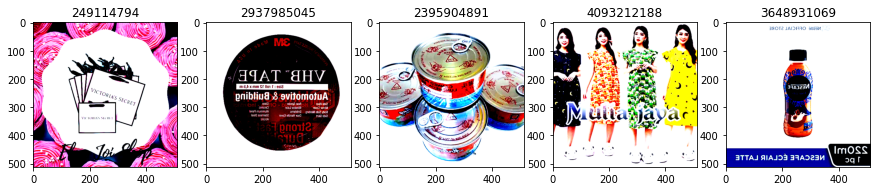

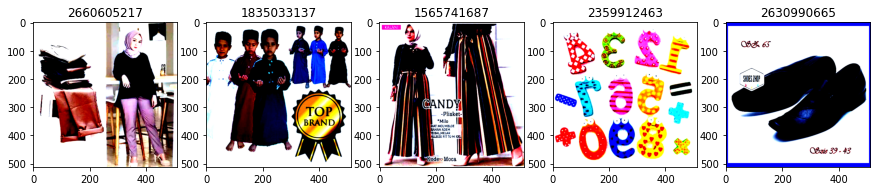

In [ ]:
dataset = SHOPEEDataset(df_train_all, 'train', transform = transforms_train)
rcParams['figure.figsize'] = 15,5
for i in range(2):
    f, axarr = plt.subplots(1,5)
    for p in range(5):
        idx = i*5 + p
        img, label = dataset[idx]
        axarr[p].imshow(img.transpose(0,1).transpose(1,2).squeeze())
        axarr[p].set_title(label.item())

In [ ]:
def arcface_loss(cosine, targ, m=.5, s=30, output_classes=11014):
    cosine = cosine.clip(-1+1e-7, 1-1e-7)
    arcosine = cosine.arccos()
    arcosine += F.one_hot(targ, num_classes = output_classes) * m
    cosine2 = arcosine.cos()
    cosine2 *= s
    return F.cross_entropy(cosine2, targ)

class ArcFaceClassifier(nn.Module):
    def __init__(self, in_features, output_classes):
        super().__init__()
        self.W = nn.Parameter(torch.Tensor(in_features, output_classes))
        nn.init.kaiming_uniform_(self.W)
    def forward(self, x):
        x_norm = F.normalize(x)
        W_norm = F.normalize(self.W, dim=0)
        return x_norm @ W_norm
    
class ResnetArcFace(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = timm.create_model(backbone_name, pretrained=True)
        embedding_size = self.backbone.get_classifier().in_features
        self.after_conv=nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.BatchNorm1d(embedding_size))   
        self.classifier = ArcFaceClassifier(embedding_size, df_train.label_group.nunique())
    
    def forward(self, x, output_embs=False):
        embeddings = self.after_conv(self.backbone.forward_features(x))
        if output_embs:
            return F.normalize(embeddings)
        return self.classifier(embeddings)

In [ ]:
model = ResnetArcFace()
model.to(device);

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [ ]:
optimizer = optim.Adam(model.parameters(), lr = init_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, n_epochs)

In [ ]:
dataset_train = SHOPEEDataset(df_train, 'train', transform = transforms_train)
dataset_valid = SHOPEEDataset(df_valid, 'test', transform = transforms_valid)

train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers = n_worker)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers = n_worker)

In [ ]:
def train_func(train_loader):
    model.train()
    bar = tqdm(train_loader)
    losses = []
    for batch_idx, (images, targets) in enumerate(bar):

        images, targets = images.to(device), targets.to(device)            
        
        cosine = model(images)
        loss = arcface_loss(cosine, targets, m=.5, s=30, output_classes=df_train.label_group.nunique())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        losses.append(loss.item())

        bar.set_description(f'loss: {loss.item():.5f}')

    loss_train = np.mean(losses)
    return loss_train

def get_embeddings(data_loader):
    model.eval()
    embs = []
    with torch.no_grad():
        for batch_idx, (images) in enumerate(tqdm(data_loader)):
            images = images.to(device)
            features = model(images, output_embs=True)
            embs += [features.detach().cpu()]
    embs = torch.cat(embs).cpu().numpy()
    return embs

In [ ]:
def row_wise_f1_score(labels, preds):
    scores = []
    for label, pred in zip(labels, preds):
        n = len(np.intersect1d(label, pred))
        score = 2 * n / (len(label)+len(pred))
        scores.append(score)
    return scores, np.mean(scores)

def find_threshold(df, embs, search_space):
    score_by_threshold = []
    best_score = 0
    best_thres = -1
    for thres in tqdm(search_space):
        thres = round(thres, 1)
        sim_matrix = ((embs@embs.T) > thres).cpu().numpy()

        pred = []
        for row in sim_matrix:
            pred.append(df.iloc[row].posting_id.tolist())

        tmp = df.groupby('label_group').posting_id.agg('unique').to_dict()
        target = df.label_group.map(tmp)
        scores, score = row_wise_f1_score(target, pred)
        
        score_by_threshold.append(score)
        if score > best_score:
            best_score = score
            best_thres = thres
            
    plt.figure(figsize=(5,5))
    plt.plot(score_by_threshold)
    plt.xlabel('threshold')
    plt.ylabel('score')
    plt.show()
    print(f'Best score is {best_score} and best threshold is {best_thres}')

  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

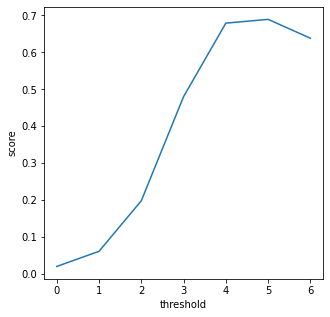

Best score is 0.6894873039959941 and best threshold is 0.8


  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

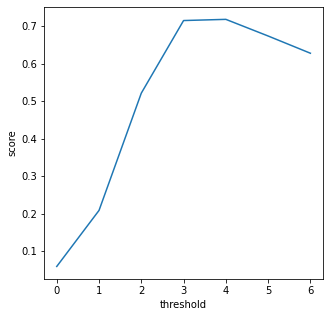

Best score is 0.7184782768073646 and best threshold is 0.7


  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

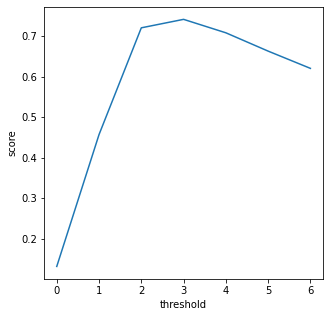

Best score is 0.7412813026766512 and best threshold is 0.6


  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

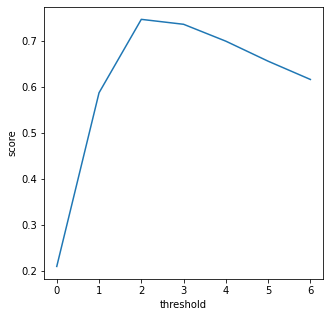

Best score is 0.7470680552739569 and best threshold is 0.5


  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

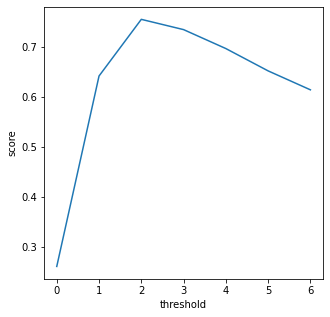

Best score is 0.7544637807740948 and best threshold is 0.5


  0%|          | 0/1713 [00:00<?, ?it/s]

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

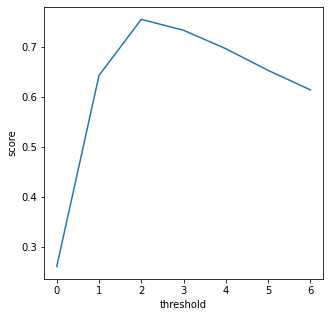

Best score is 0.7544082880847321 and best threshold is 0.5


In [ ]:
for epoch in range(n_epochs):
    scheduler.step()
    loss_train = train_func(train_loader)

    if epoch % valid_every == 0: 
        embs = get_embeddings(valid_loader)
        embs = torch.tensor(embs).cuda()
        find_threshold(df_valid, embs, search_space)

        if epoch >= save_after:
            torch.save(model.state_dict(), os.path.join(model_dir, f'{backbone_name}_{image_size}_epoch{epoch+1}.pth'))

In [ ]:
embs = get_embeddings(valid_loader)

  0%|          | 0/429 [00:00<?, ?it/s]

  0%|          | 0/7 [00:00<?, ?it/s]

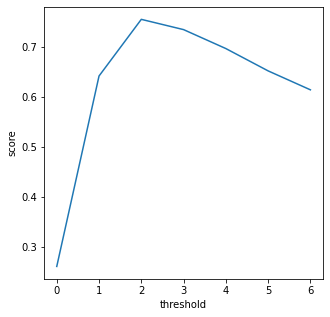

Best score is 0.7544637807740948 and best threshold is 0.5


In [ ]:
embs = torch.tensor(embs).cuda()
find_threshold(df_valid, embs, search_space)